# Final Project

In [3]:
import serial, time

ModuleNotFoundError: No module named 'serial'

## Data Collection
Run below cells to collect twitch data

In [4]:
resolution = 100
duration = 10

# Setup Serial Communication
ser = serial.Serial('COM4') # TODO: Check if correct COM/TTYL port
ser.baudrate = 9600
start_time = time.time()

# Start Data Logging
f = open('{0}.txt'.format(start_time), "w")
while True:
    curr_time = time.time()
    if (curr_time - start_time > duration):
        break
    ser.write(str.encode('l'))
    f.write(str(ser.readline()))
ser.close()
f.close()


NameError: name 'serial' is not defined

## Model Fitting
https://www.tensorflow.org/lite/microcontrollers 

https://github.com/tensorflow/decision-forests

In [11]:
import sys
!python -m pip install -r requirements.txt

  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached libclang-14.0.6-py2.py3-none-win_amd64.whl (14.2 MB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Using cached flatbuffers-22.12.6-py2.py3-none-any.whl (26 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached absl_py-1.3.0-py3-none-any.whl (124 kB)
  Using cached tensorboard-2.11.0-py3-none-any.whl (6.0 MB)
  Using cached termcolor-2.1.1-py3-none-any.whl (6.2 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.utils

#### Load and Preprocess Data

In [34]:
def load_data(file_num, path=''):
    motion_file = f'{path}/motion/{file_num}_acceleration.txt'
    sleep_file  = f'{path}/labels/{file_num}_labeled_sleep.txt'
    motion_data = pd.read_csv(motion_file, delimiter=' ', names=['time', 'x', 'y', 'z'])
    sleep_data  = pd.read_csv(sleep_file, delimiter=' ', names=['time', 'label'])
    return motion_data, sleep_data

def assign_sleep_to_motion(motion, sleep):
    labels = []
    index = 0
    for t in range(len(motion)):
        if (t > sleep['time'][index]):
            index += 1
        labels.append(sleep['label'][index])
    data = np.array([motion['time'], motion['x'], motion['y'], motion['z'], labels]).T
    df = pd.DataFrame(data, columns=['time', 'x', 'y', 'z', 'label'])
    df = df.loc[df['label'] > -1]
    return df

def match_motion_to_sleep(motion, sleep):
    _, _, indices = np.intersect1d(sleep['time'], motion['time'], return_indices=True)
    data = np.array([sleep['time'], 
                    motion['x'][indices], 
                    motion['y'][indices], 
                    motion['z'][indices], 
                    sleep['label']]).T
    df = pd.DataFrame(data, columns=['time', 'x', 'y', 'z', 'label'])
    df = df.loc[df['label'] > -1]
    return df

def get_motion_average(motion):
    motion_time = np.clip(np.floor(motion['time']), min(sleep['time']), max(sleep['time']))
    motion_time, motion_indices = np.unique(motion_time, return_index=True)
    avg_x = np.array([np.average(motion['x'][i]) for i in motion_indices])
    avg_y = np.array([np.average(motion['y'][i]) for i in motion_indices])
    avg_z = np.array([np.average(motion['z'][i]) for i in motion_indices])
    data = np.array([motion_time, avg_x, avg_y, avg_z]).T
    df = pd.DataFrame(data, columns=['time', 'x', 'y', 'z'])
    return df

def plot_data(df, title=''):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_title(title)
    plot = lambda d, c, m : ax.scatter3D(d['x'], d['y'], d['z'], c=c, marker=m)
    colors = ['r', 'm', 'y', 'g', 'b', 'c']
    [plot(df.loc[df['label'] == i], colors[i], '.') for i in range(6)]
    

In [35]:
path = './data'
file_nums = ['46343', '1066528', '781756']

motion, sleep = load_data(file_nums[0], './data')

avg_motion = get_motion_average(motion)

matched_time_data_average_df = match_motion_to_sleep(avg_motion, sleep)
assigned_time_data_average_df = assign_sleep_to_motion(avg_motion, sleep)

# plot_data(matched_time_data_average_df, f'matched {file_nums[0]}')
# plot_data(assigned_time_data_average_df, f'assigned {file_nums[0]}')


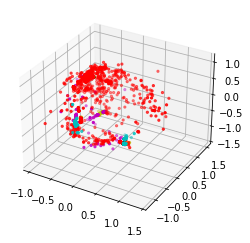

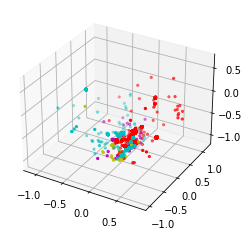

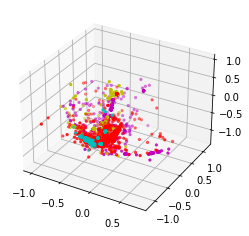

In [36]:
data = [load_data(file_nums[i], './data') for i in range(3)]
prep_func = lambda d: assign_sleep_to_motion(get_motion_average(d[0]), d[1])
train_data, valid_data, test_data = [sklearn.utils.shuffle(prep_func(d)) for d in data]
[plot_data(d) for d in (train_data, valid_data, test_data)]
x_train, x_valid, x_test = [np.array([d['x'], d['y'], d['z']]).T for d in (train_data, valid_data, test_data)]
y_train, y_valid, y_test  = [d['label'] for d in (train_data, valid_data, test_data)]

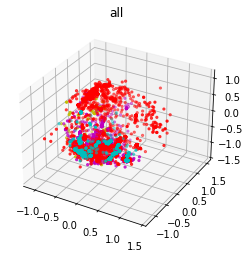

In [39]:
file_nums = ['46343', '1066528', '781756']
prep_func = lambda d: assign_sleep_to_motion(get_motion_average(d[0]), d[1])
data = [load_data(num, './data') for num in file_nums]
df = pd.concat([prep_func(d) for d in data], axis=0, ignore_index=True)
# df.reset_index(drop=True)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title("all")
plot = lambda d, c, m : ax.scatter3D(d['x'], d['y'], d['z'], c=c, marker=m)
colors = ['r', 'm', 'y', 'g', 'b', 'c']
[plot(df.loc[df['label'] == i], colors[i], '.') for i in range(6)]

#### Train Model

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [13]:
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

In [14]:
%%capture
# Simple Neural Network
model = tf.keras.Sequential()
model.add(keras.layers.Dense(8, activation='relu', input_shape=(3,)))
model.add(keras.layers.Dense(1))

# Compile and fit
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_valid, y_valid))

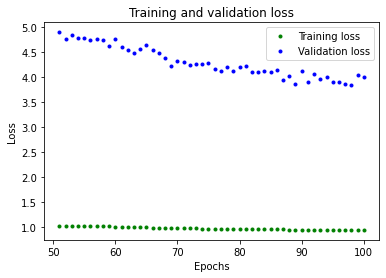

In [16]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

SKIP = 50

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

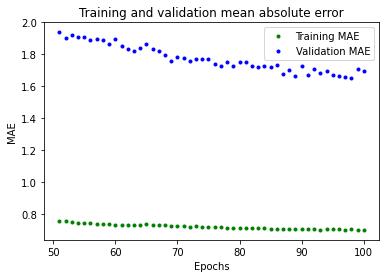

In [18]:
plt.clf()

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

528/528 [==============================] - 0s 451us/step


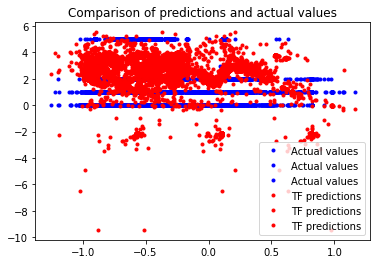

In [19]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predictions')
plt.legend()
plt.show()

#### Convert Tflite model for microcontroler

In [16]:
# def representative_dataset():
#     for _ in range(500):
#       data = np.random.rand(1,3)
#       yield [data.astype(np.float32)]

In [8]:
# Convert and sove
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8
# converter.inference_output_type = tf.int8
# converter.representative_dataset = representative_dataset
tflite_model = converter.convert()
with open('model/model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpo408ga0j/assets


2022-12-16 14:15:30.823594: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-16 14:15:30.823633: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-16 14:15:30.823749: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpo408ga0j
2022-12-16 14:15:30.824110: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-16 14:15:30.824117: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpo408ga0j
2022-12-16 14:15:30.826056: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-12-16 14:15:30.826423: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-12-16 14:15:30.843350: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpo408ga0j
2022-12

In [10]:
!xxd -i model/model.tflite > model/model.cpp
# Update variable names
REPLACE_TEXT = 'model/model.tflite'.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {'model/model.cpp'}
!cp model/model.cpp lib/model/model.cpp